In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [25]:
path2data = './gan_data'
os.makedirs(path2data, exist_ok=True)

In [26]:
train_ds = datasets.MNIST(path2data, train=True,
                         transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],
                                                                                                   [0.5])]), download=True)

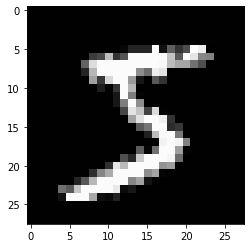

In [27]:
img, label = train_ds[0]
plt.imshow(to_pil_image(img), cmap='gray')

In [28]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

for x,y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [29]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.nz = params['nz']
        self.img_size = params['img_size']
        
        self.model = nn.Sequential(
            *self._fc_layer(self.nz, 128, normalize=False),
            *self._fc_layer(128,256),
            *self._fc_layer(256,512),
            *self._fc_layer(512,1024),
            nn.Linear(1024, int(np.prod(self.img_size))),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_size)
        return img
    
    def _fc_layer(self, in_channels, out_channels, normalize=True):
        layers = []
        layers.append(nn.Linear(in_channels, out_channels))
        if normalize:
            layers.append(nn.BatchNorm1d(out_channels, 0.8))
        layers.append(nn.LeakyReLU(0.2))
        return layers
    
params = {'nz': 100,
         'img_size':(1,28,28)}
x = torch.randn(16,100).to(device)
model_gen = Generator(params).to(device)
output = model_gen(x)
print(output.shape)

torch.Size([16, 1, 28, 28])


In [30]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.img_size = params['img_size']
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

x = torch.randn(16,1,28,28).to(device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
print(output.shape)

torch.Size([16, 1])


In [31]:
def initialize_weights(model):
    classname = model.__class__.__name__
    
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0,0.02)
        nn.init.constant_(model.bias.data, 0)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [32]:
loss_func = nn.BCELoss()

from torch import optim

lr = 2e-4
beta1=0.5

opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas = (beta1,0.999))
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas = (beta1,0.999))

In [33]:
real_label =1.
fake_label =0.
nz = params['nz']
num_epochs = 100

loss_history= {'gen':[],
               'dis':[]}

In [34]:
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.size(0)
        
        xb = xb.to(device)
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device)
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device)
        
        model_gen.zero_grad()
        noise = torch.randn(ba_si, nz, device=device)
        out_gen =model_gen(noise)
        out_dis = model_dis(out_gen)
        
        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()
        
        model_dis.zero_grad()
        
        out_real = model_dis(xb)
        out_fake = model_dis(out_gen.detach())
        loss_real = loss_func(out_real, yb_real)
        loss_fake = loss_func(out_fake, yb_fake)
        loss_dis = (loss_real + loss_fake) / 2
        
        loss_dis.backward()
        opt_dis.step()
        
        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())
        
        batch_count +=1
        if batch_count % 1000 ==0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(),
                                                                             loss_dis.item(), (time.time() - start_time)/60))


Epoch: 0, G_Loss: 2.686524, D_Loss: 0.219957, time: 0.15 min
Epoch: 1, G_Loss: 1.111425, D_Loss: 0.294846, time: 0.29 min
Epoch: 1, G_Loss: 1.706105, D_Loss: 0.339342, time: 0.44 min
Epoch: 2, G_Loss: 4.363388, D_Loss: 0.812080, time: 0.59 min
Epoch: 2, G_Loss: 1.833733, D_Loss: 0.259681, time: 0.76 min
Epoch: 3, G_Loss: 3.040741, D_Loss: 0.446609, time: 0.90 min
Epoch: 3, G_Loss: 1.390725, D_Loss: 0.285725, time: 1.05 min
Epoch: 4, G_Loss: 2.242678, D_Loss: 0.690893, time: 1.20 min
Epoch: 4, G_Loss: 1.518064, D_Loss: 0.289390, time: 1.36 min
Epoch: 5, G_Loss: 2.164684, D_Loss: 0.181252, time: 1.51 min
Epoch: 5, G_Loss: 3.545590, D_Loss: 0.215853, time: 1.65 min
Epoch: 6, G_Loss: 2.507548, D_Loss: 0.389109, time: 1.80 min
Epoch: 6, G_Loss: 3.255496, D_Loss: 0.374684, time: 1.96 min
Epoch: 7, G_Loss: 2.075268, D_Loss: 0.225709, time: 2.11 min
Epoch: 7, G_Loss: 1.896685, D_Loss: 0.304680, time: 2.26 min
Epoch: 8, G_Loss: 2.516958, D_Loss: 0.463798, time: 2.41 min
Epoch: 9, G_Loss: 1.1779

Epoch: 70, G_Loss: 2.130124, D_Loss: 0.228401, time: 20.04 min
Epoch: 71, G_Loss: 2.088840, D_Loss: 0.226489, time: 20.19 min
Epoch: 71, G_Loss: 1.784649, D_Loss: 0.309598, time: 20.35 min
Epoch: 72, G_Loss: 2.153725, D_Loss: 0.291606, time: 20.49 min
Epoch: 73, G_Loss: 2.222868, D_Loss: 0.272761, time: 20.64 min
Epoch: 73, G_Loss: 1.652388, D_Loss: 0.251170, time: 20.82 min
Epoch: 74, G_Loss: 2.009182, D_Loss: 0.173552, time: 20.96 min
Epoch: 74, G_Loss: 2.578509, D_Loss: 0.213680, time: 21.11 min
Epoch: 75, G_Loss: 2.225499, D_Loss: 0.292452, time: 21.25 min
Epoch: 75, G_Loss: 2.320677, D_Loss: 0.212836, time: 21.40 min
Epoch: 76, G_Loss: 1.222275, D_Loss: 0.291438, time: 21.57 min
Epoch: 76, G_Loss: 2.210193, D_Loss: 0.157397, time: 21.72 min
Epoch: 77, G_Loss: 1.782999, D_Loss: 0.364072, time: 21.89 min
Epoch: 77, G_Loss: 2.321247, D_Loss: 0.193463, time: 22.03 min
Epoch: 78, G_Loss: 2.717659, D_Loss: 0.253160, time: 22.17 min
Epoch: 78, G_Loss: 3.585983, D_Loss: 0.220724, time: 22

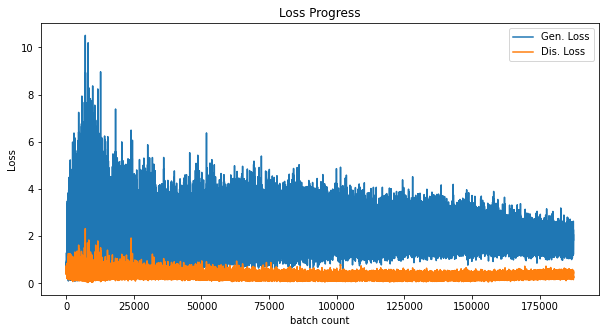

In [35]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [37]:
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evaluation mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


tensor([[ 0.7723, -1.1918,  0.6274,  ..., -0.0833, -0.2863, -0.2501],
        [ 0.1867, -0.0550,  1.2680,  ...,  1.5707, -0.7410, -0.5311],
        [ 0.8721,  1.2469, -1.8917,  ...,  1.7014, -0.4903, -1.5402],
        ...,
        [-1.6612, -0.6921,  0.2913,  ..., -1.6074, -1.4969, -0.2989],
        [-1.0272,  0.0182,  0.7338,  ..., -0.1574,  0.4436, -0.3920],
        [-1.8295,  0.3320, -0.0077,  ..., -0.3436,  1.6346, -0.1234]],
       device='cuda:0')


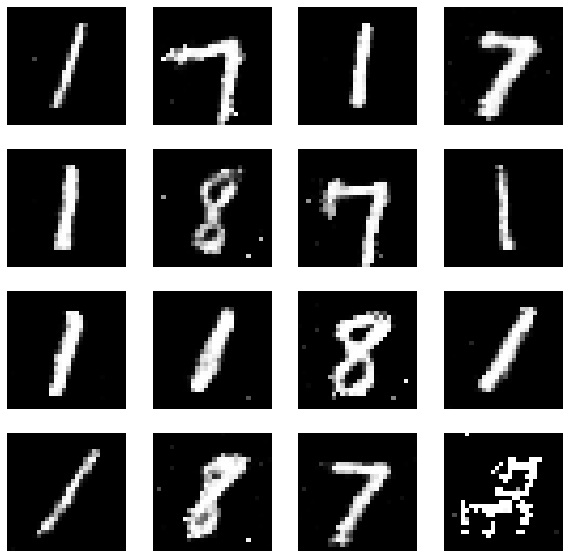

In [39]:
plt.figure(figsize=(10,10))
print(fixed_noise)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5),cmap='gray')
    plt.axis('off')